In [1]:
%load_ext autoreload
%autoreload 2

import optuna
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import shap
import numpy as np
import scipy
import seaborn as sns
import lightgbm as lgb
import numpy as np
import sklearn.datasets
import sklearn.metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
import pickle

from utils.model import Metrics, save_model, load_model

import matplotlib as mpl

mpl.rcParams["figure.dpi"] = 200

SEED = 42

In [2]:
from utils.pipeline import Pipeline, PipelineStep

from utils.helpers import reduce_mem_usage
from transform.set_missings import set_missings, drop_fraud
from transform.load_data import load_train_data, load_test_data
from transform.feature_selection import feature_selection
from transform.dpi_features import generate_test_dpi_feature, generate_train_dpi_feature
from transform.bnum_features import generate_test_bnum_feature, generate_train_bnum_feature
from transform.fe_features import generate_test_fe_feature, generate_train_fe_feature


def remove_abon_id(df):
    return df.drop("abon_id", axis=1)


transform_train_pipeline = Pipeline(
    "TRANSFORM_TRAIN",
    [
        # Load data
        PipelineStep(load_train_data),
        PipelineStep(set_missings),
        # New features
        PipelineStep(generate_train_fe_feature),
        PipelineStep(generate_train_dpi_feature),
        PipelineStep(generate_train_bnum_feature),
        PipelineStep(drop_fraud),
        # Feature selection
        PipelineStep(remove_abon_id),
        PipelineStep(feature_selection),
    ],
)

transform_test_pipeline = Pipeline(
    "TRANSFORM_TEST",
    [
        # Load data
        PipelineStep(load_test_data),
        PipelineStep(set_missings),
        # New features
        PipelineStep(generate_test_fe_feature),
        PipelineStep(generate_test_dpi_feature),
        PipelineStep(generate_test_bnum_feature),
        # Feature selection
        PipelineStep(remove_abon_id),
        PipelineStep(feature_selection),
    ],
)

train_data = transform_train_pipeline.run()

train_data.target = train_data.target.astype(int)

print("Shape:", train_data.shape)

2024-08-05 12:00:48 - Running pipeline: TRANSFORM_TRAIN (0:00:00)
2024-08-05 12:00:48 - 0. Running step: load_train_data (0:00:00)
2024-08-05 12:00:48 - 1. Running step: set_missings (0:00:00)
2024-08-05 12:00:51 - 2. Running step: generate_train_fe_feature (0:00:03)
2024-08-05 12:00:52 - 3. Running step: generate_train_dpi_feature (0:00:04)
2024-08-05 12:00:54 - 4. Running step: generate_train_bnum_feature (0:00:06)
2024-08-05 12:00:56 - 5. Running step: drop_fraud (0:00:08)
2024-08-05 12:00:57 - 6. Running step: remove_abon_id (0:00:08)
2024-08-05 12:00:57 - 7. Running step: feature_selection (0:00:09)
2024-08-05 12:00:57 - 9. Done (0:00:09)


-----------------

Shape: (149998, 59)


In [4]:
from transform.load_data import LoadData

loader = LoadData()

NOT_CHURNED_CLIENT_TITLE = "Stayed clients"
CHURNED_CLIENT_TITLE = "Churned clients"

NOT_CHURNED_COLOR = "#80CAFF"
CHURNED_COLOR = "#FFAFA3"

SNS_TARGET_LABELS = [CHURNED_CLIENT_TITLE, NOT_CHURNED_CLIENT_TITLE]

# loader.df_train_fe -> (150000, 817)
# loader.df_test_fe -> (150000, 817)

# loader.df_train_bnum -> (671248, 8)
# loader.df_test_bnum -> (669540, 8)

# loader.df_train_dpi -> (6745887, 6)
# loader.df_test_dpi -> (6739211, 6)

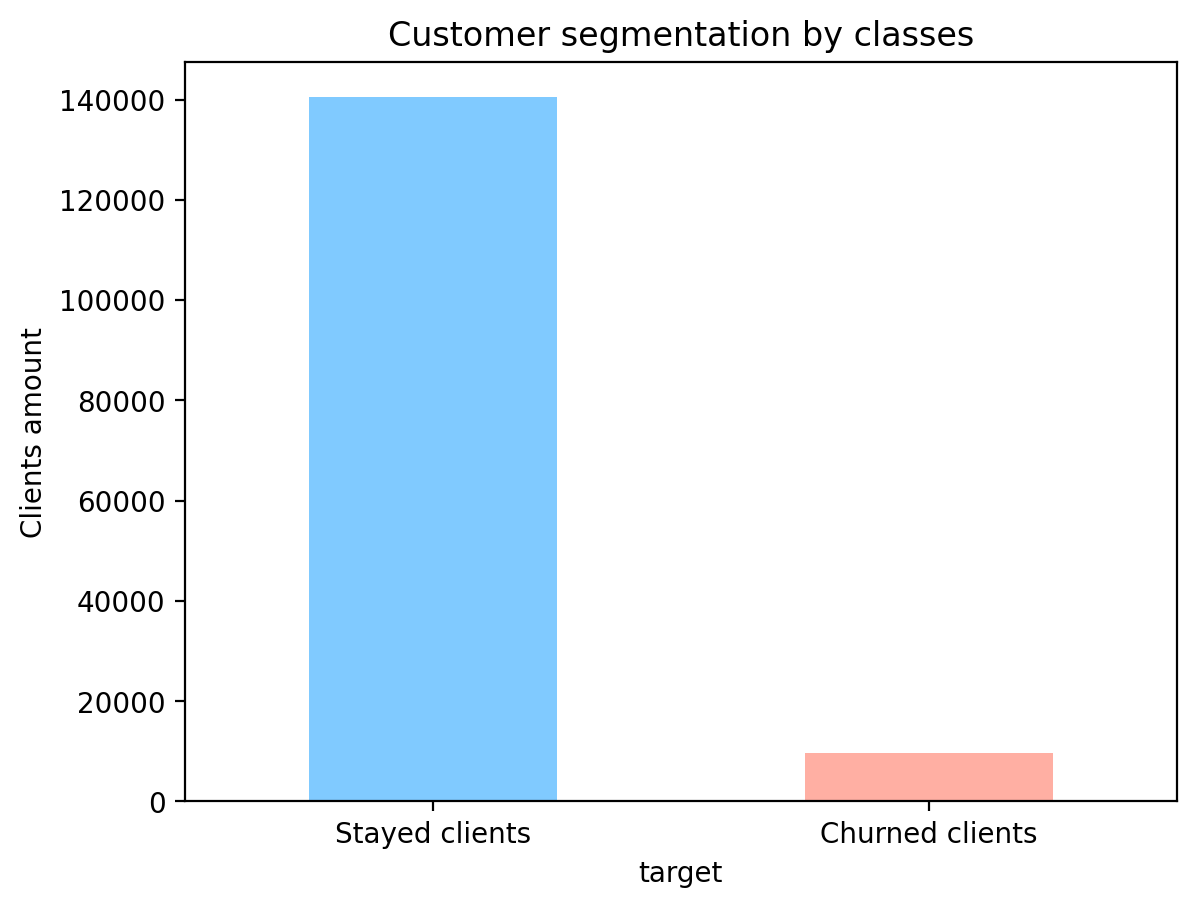

In [4]:
ax = (
    loader.df_train_fe["target"]
    .value_counts()
    .plot(kind="bar", title="Customer segmentation by classes", color=[NOT_CHURNED_COLOR, CHURNED_COLOR])
)
ax.set_xticklabels([NOT_CHURNED_CLIENT_TITLE, CHURNED_CLIENT_TITLE], rotation=0)

plt.ylabel("Clients amount")
plt.show()

In [5]:
df = set_missings(loader.df_train_fe.copy())

not_churn_clients = df[df.target == 0]
churn_clients = df[df.target == 1]

In [ ]:
missing_values = loader.df_train_fe.isnull().sum() * 100 / len(loader.df_train_fe)

missing_values.Balance_uah

0.0

In [ ]:
loader.df_train_fe[~loader.df_train_fe.day_end_gba.isnull()].target.value_counts()

target
0.0    11254
1.0      249
Name: count, dtype: int64

In [ ]:
# import plotly.figure_factory as ff
# import numpy as np

# # Generate sample data
# data1 = not_churn_clients.device_days_usage
# data2 = churn_clients.device_days_usage

# # Create distribution plots
# fig = ff.create_distplot(
#     [data1, data2],
#     group_labels=[NOT_CHURNED_CLIENT_TITLE, CHURNED_CLIENT_TITLE],
#     bin_size=10,
# )

# # Update layout for better visualization
# fig.update_layout(
#     title="Розподіл клієнтів по 'Кількості днів використання'",
#     xaxis_title="Кількість днів",
#     yaxis_title="Щільність",
#     autosize=True,
#     width=800,
#     height=500,
#     font=dict(size=14),
#     legend=dict(font=dict(size=16)),
#     margin=dict(l=20, r=250, t=100, b=20),
# )

# # Show plot
# fig.show()

# fig.write_image("device_days_usage_distribution.png", scale=3)

/Users/yaroslav/.pyenv/versions/3.10.13/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yaroslav/.pyenv/versions/3.10.13/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/yaroslav/.pyenv/versions/3.10.13/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


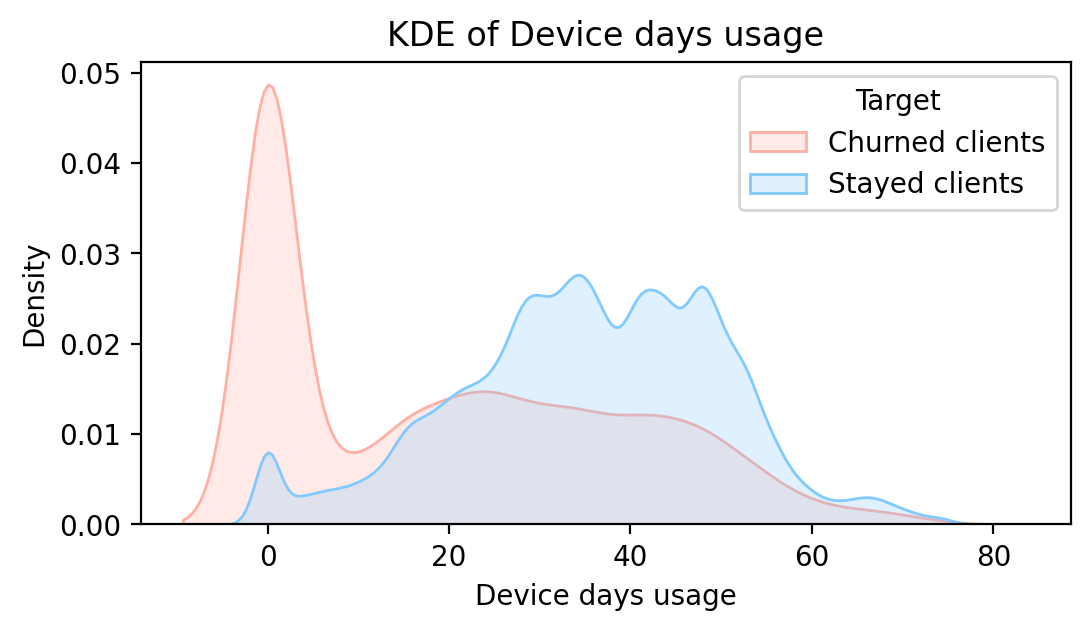

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 3))
sns.kdeplot(
    data=df,
    x="device_days_usage",
    hue="target",
    fill=True,
    palette={0: NOT_CHURNED_COLOR, 1: CHURNED_COLOR},
    common_norm=False,
)
# Eng
plt.title("KDE of Device days usage")
plt.xlabel("Device days usage")
plt.ylabel("Density")
plt.legend(title="Target", labels=SNS_TARGET_LABELS)
plt.show()

# plt.savefig("device_days_usage_kde.png")

/Users/yaroslav/.pyenv/versions/3.10.13/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yaroslav/.pyenv/versions/3.10.13/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/yaroslav/.pyenv/versions/3.10.13/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


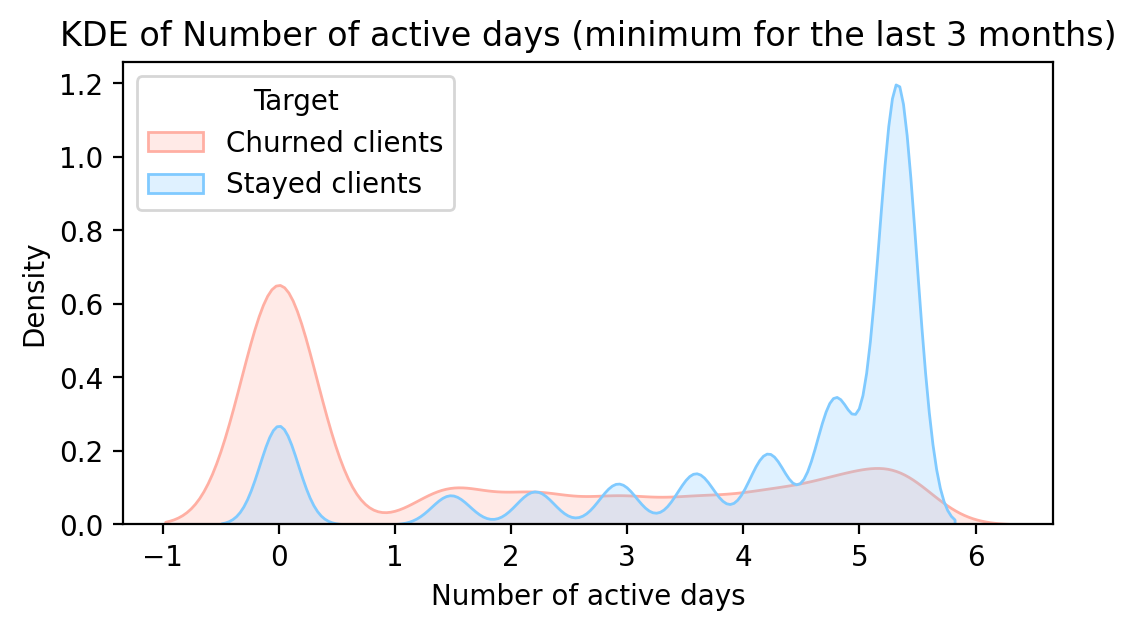

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 3))
sns.kdeplot(
    data=df,
    x="num_act_days_min_mnt3",
    hue="target",
    fill=True,
    palette={0: NOT_CHURNED_COLOR, 1: CHURNED_COLOR},
    common_norm=False,
)
plt.title("KDE of Number of active days (minimum for the last 3 months)")
plt.xlabel("Number of active days")
plt.ylabel("Density")
plt.legend(title="Target", labels=SNS_TARGET_LABELS, loc="upper left")
plt.show()

# plt.savefig("num_act_days_min_mnt3_kde.png")

/Users/yaroslav/.pyenv/versions/3.10.13/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/yaroslav/.pyenv/versions/3.10.13/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



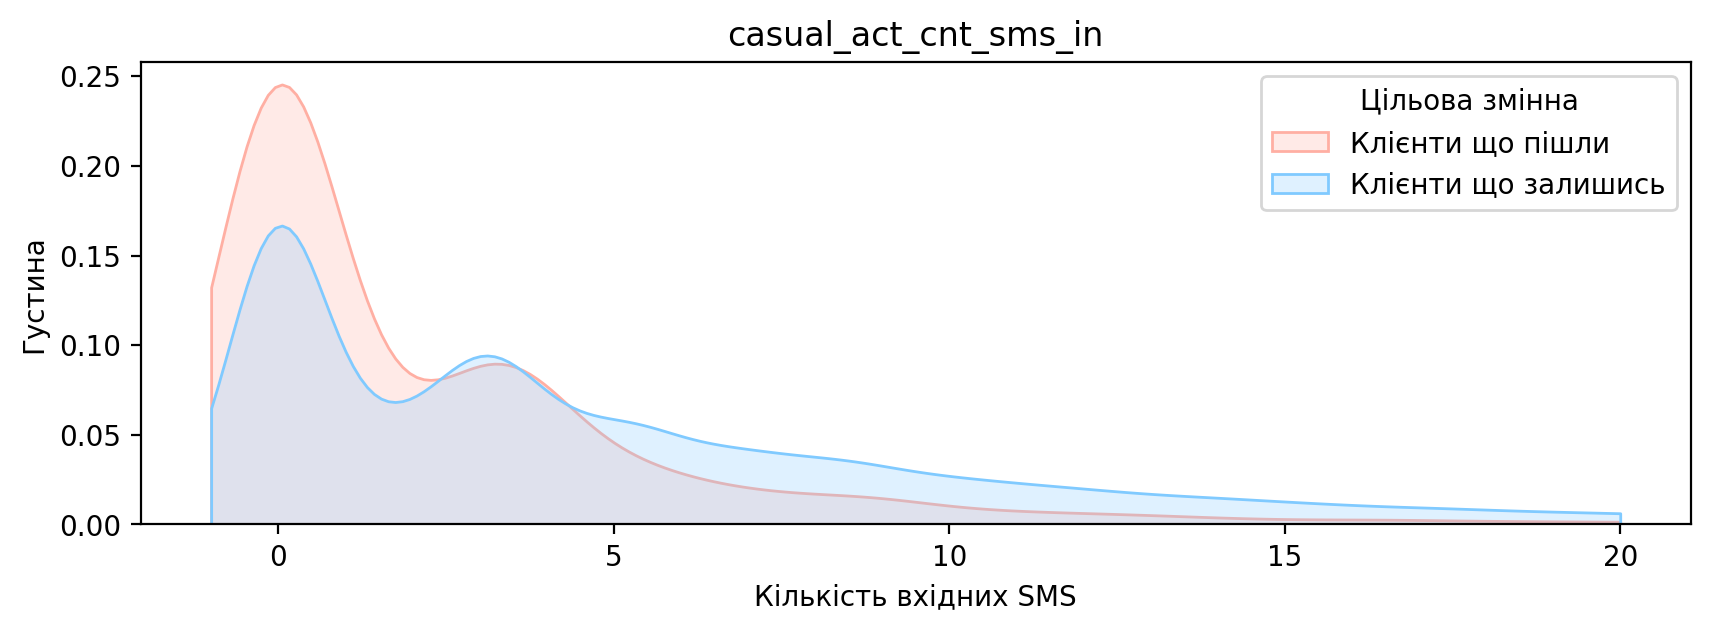

<Figure size 1280x960 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 3))
sns.kdeplot(
    data=train_data,
    x="casual_act_cnt_sms_in",
    hue="target",
    fill=True,
    palette={0: NOT_CHURNED_COLOR, 1: CHURNED_COLOR},
    common_norm=False,
    clip=(-1, 20),
)
plt.title("casual_act_cnt_sms_in")
plt.xlabel("Кількість вхідних SMS")
plt.ylabel("Щільність")
plt.legend(title="Цільова змінна", labels=SNS_TARGET_LABELS)
plt.show()

plt.savefig("casual_act_cnt_sms_in_kde.png")

/Users/yaroslav/.pyenv/versions/3.10.13/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yaroslav/.pyenv/versions/3.10.13/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


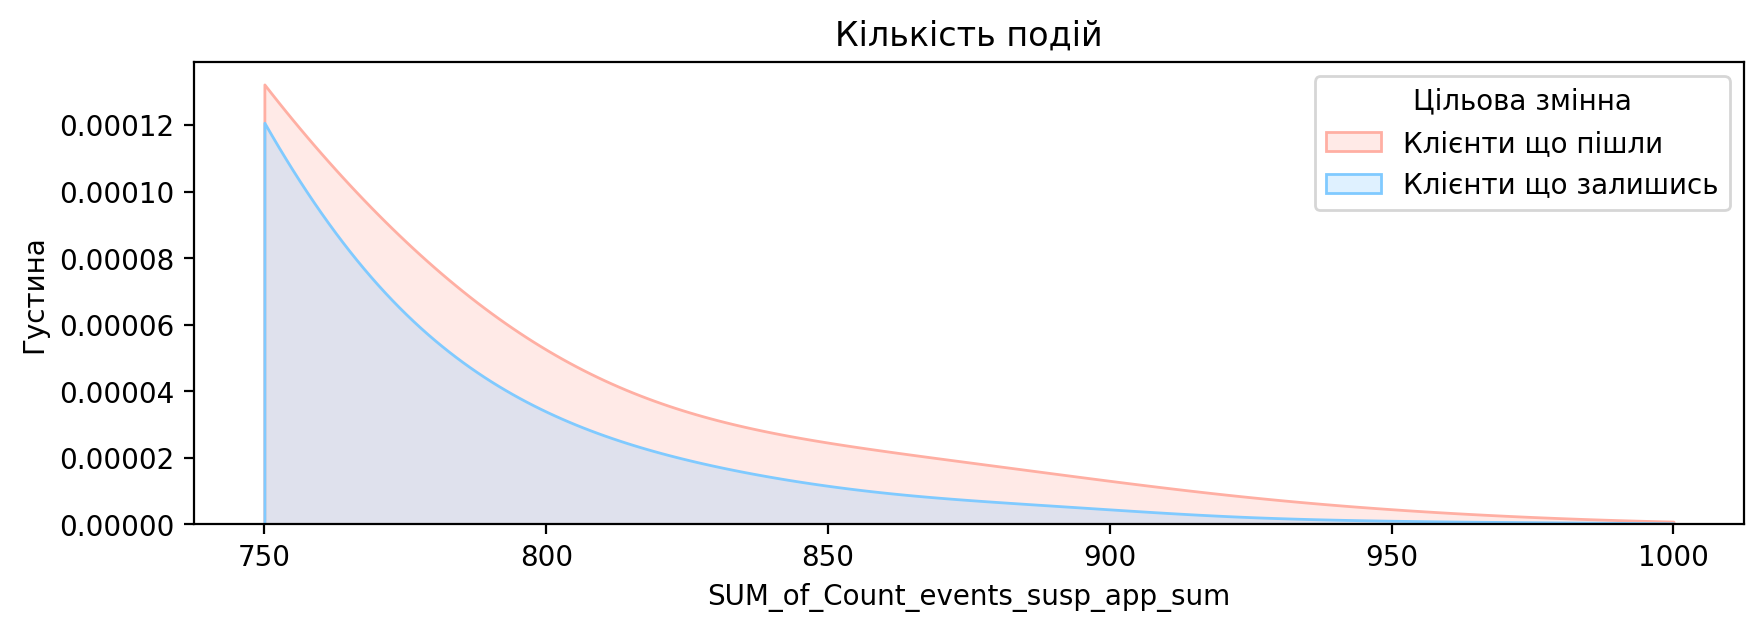

<Figure size 1280x960 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 3))
sns.kdeplot(
    data=train_data,
    x="SUM_of_Count_events_susp_app_sum",
    hue="target",
    fill=True,
    palette={0: NOT_CHURNED_COLOR, 1: CHURNED_COLOR},
    common_norm=False,
    clip=(750, 1000),
)
plt.title(DPI_MAPPER["SUM_of_Count_events"])
plt.xlabel("SUM_of_Count_events_susp_app_sum")
plt.ylabel("Густина")
plt.legend(title="Цільова змінна", labels=SNS_TARGET_LABELS)
plt.show()

# plt.savefig("casual_act_cnt_sms_in_kde.png")
plt.savefig("casual_act_cnt_sms_in_kde.png")

In [ ]:
import pandas as pd
import plotly.express as px

# Copying the DataFrame and ensuring correct data types
df = train_data.copy()

# Converting columns to integer type
df["target"] = df["target"].astype(int)
df["device_days_usage"] = df["device_days_usage"].astype(int)
df["loc_market_share"] = df["loc_market_share"].astype("float32")
df["device_sim_count"] = df["device_sim_count"].astype("float32")  # Ensure this column is also numeric
df["lt"] = df["lt"].astype("float32")  # Ensure this column is also numeric

# Checking for any missing values in the relevant columns
if df[["device_days_usage", "loc_market_share", "target", "device_sim_count"]].isnull().values.any():
    raise ValueError("There are missing values in one or more of the columns used for the plot.")

# Creating the scatter plot
fig = px.scatter(
    df,
    x="lt",
    y="device_days_usage",
    color="target",
)

# Showing the plot
fig.show()

/Users/yaroslav/.pyenv/versions/3.10.13/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yaroslav/.pyenv/versions/3.10.13/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


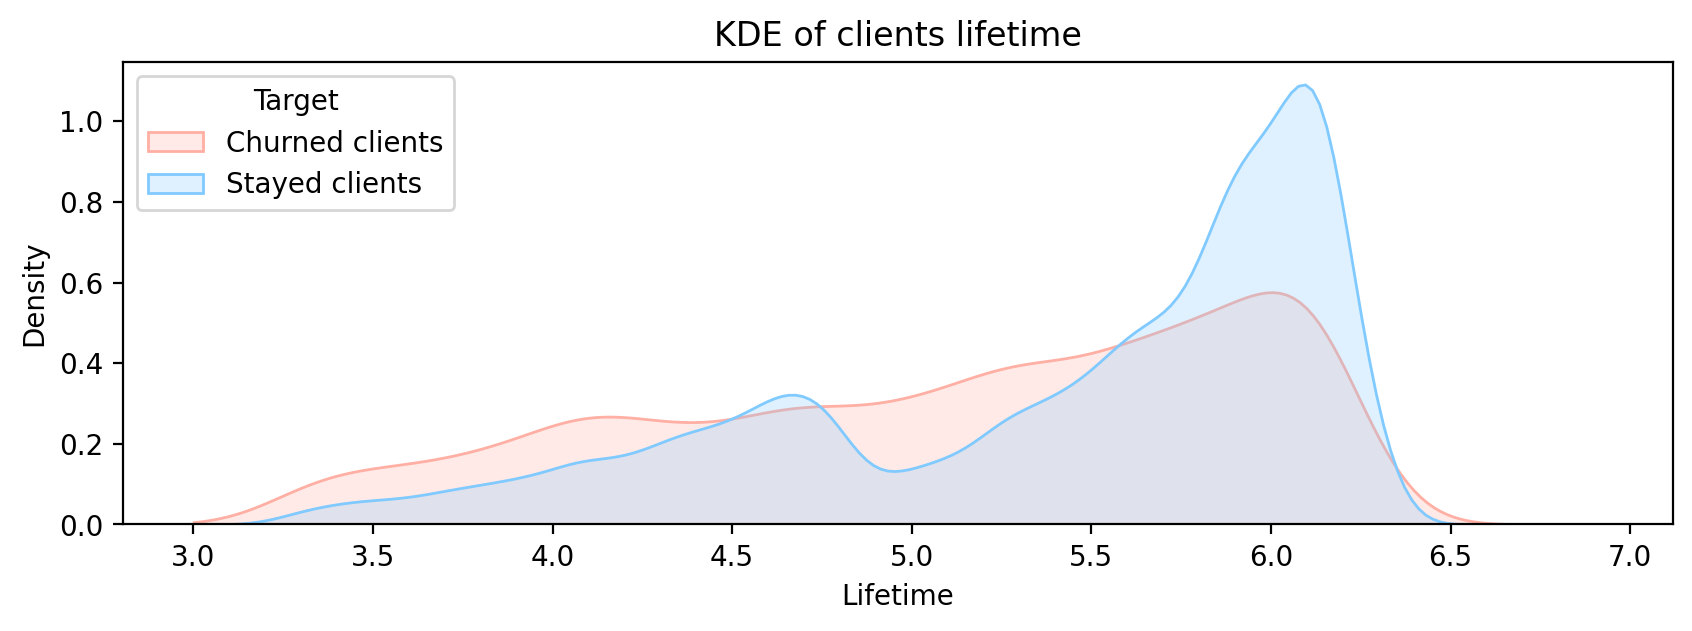

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 3))
sns.kdeplot(
    data=train_data,
    x="lt",
    hue="target",
    fill=True,
    palette={0: NOT_CHURNED_COLOR, 1: CHURNED_COLOR},
    common_norm=False,
    clip=(3, 7),
)
plt.title("KDE of clients lifetime")
plt.xlabel("Lifetime")
plt.ylabel("Density")
plt.legend(title="Target", labels=SNS_TARGET_LABELS, loc="upper left")
plt.show()

# plt.savefig("casual_act_cnt_sms_in_kde.png")
# plt.savefig("lt_kde.png")

/Users/yaroslav/.pyenv/versions/3.10.13/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yaroslav/.pyenv/versions/3.10.13/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


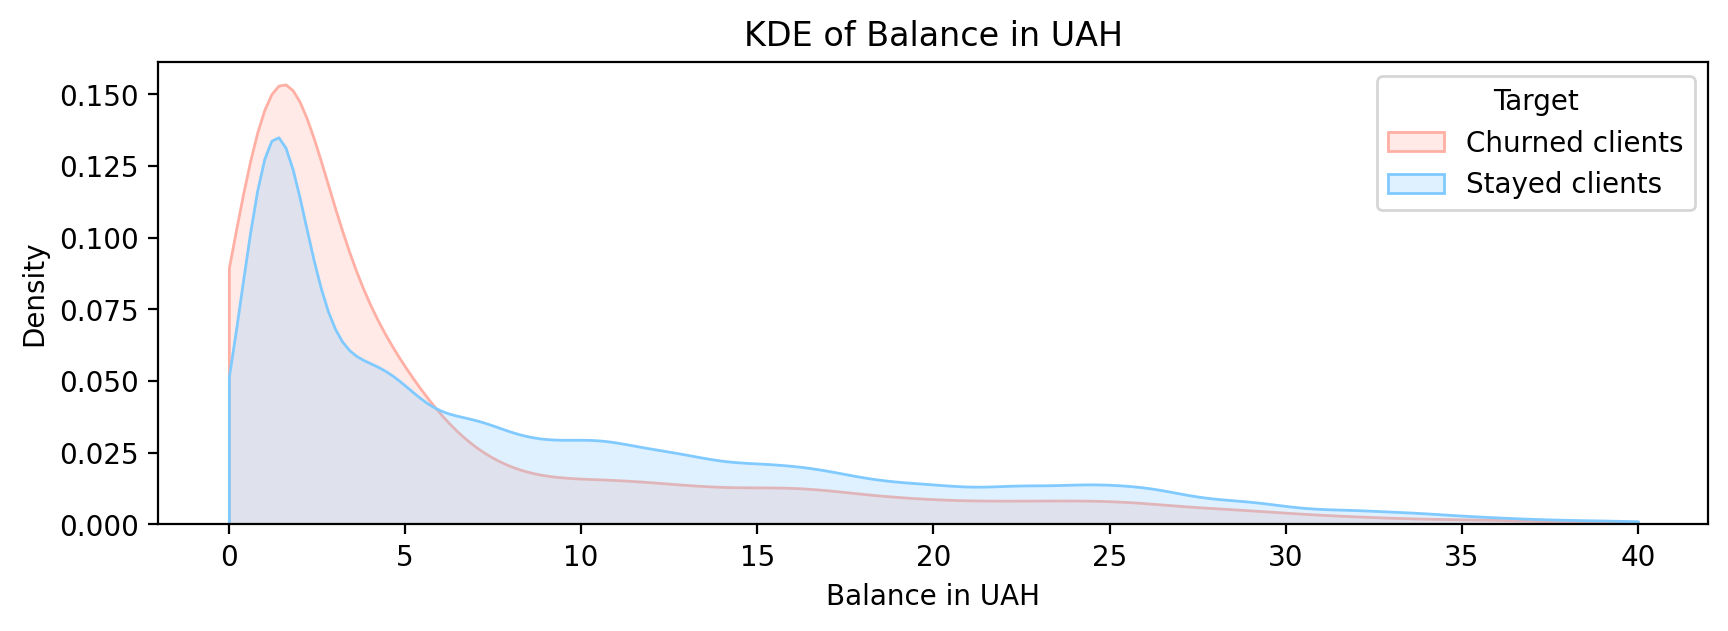

<Figure size 1280x960 with 0 Axes>

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 3))
sns.kdeplot(
    data=train_data,
    x="Balance_uah",
    hue="target",
    fill=True,
    palette={0: NOT_CHURNED_COLOR, 1: CHURNED_COLOR},
    common_norm=False,
    clip=(0, 40),
)
plt.title("KDE of Balance in UAH")
plt.xlabel("Balance in UAH")
plt.ylabel("Density")
plt.legend(title="Target", labels=SNS_TARGET_LABELS, loc="upper right")
plt.show()

# plt.savefig("casual_act_cnt_sms_in_kde.png")
plt.savefig("balance_uah.png")

/Users/yaroslav/.pyenv/versions/3.10.13/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yaroslav/.pyenv/versions/3.10.13/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


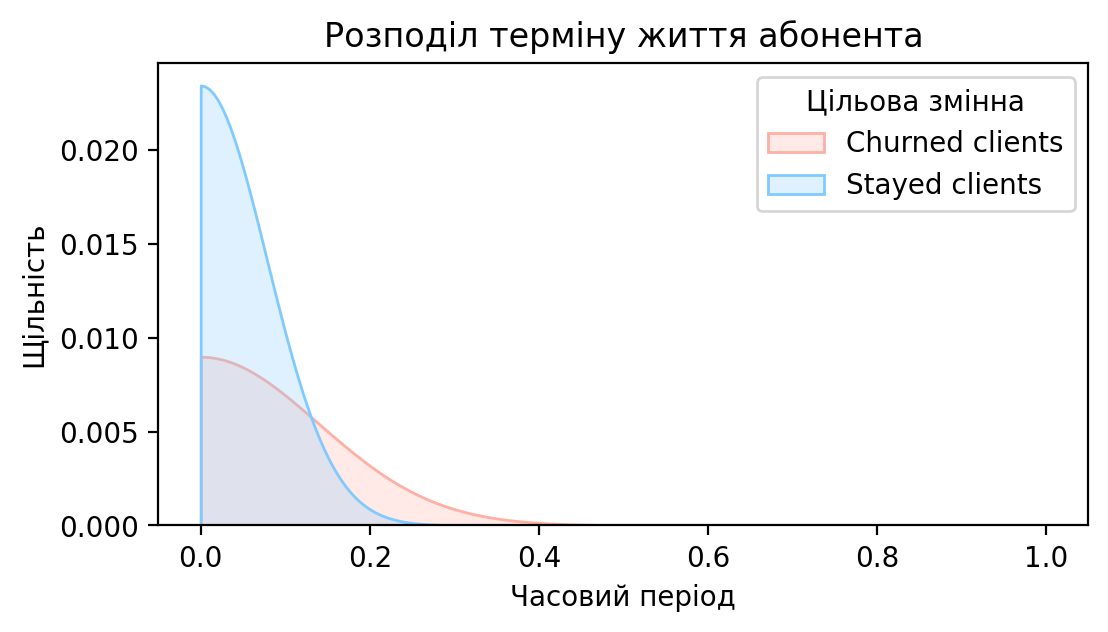

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 3))
sns.kdeplot(
    data=train_data,
    x="lt",
    hue="target",
    fill=True,
    palette={0: NOT_CHURNED_COLOR, 1: CHURNED_COLOR},
    common_norm=False,
    clip=(0, 1),
)
plt.title("Розподіл терміну життя абонента")
plt.xlabel("Часовий період")
plt.ylabel("Щільність")
plt.legend(title="Цільова змінна", labels=SNS_TARGET_LABELS)
plt.show()

# plt.savefig("casual_act_cnt_sms_in_kde.png")
# plt.savefig("lt_kde_short.png")

In [7]:
DPI_MAPPER = {
    "SUM_of_Duration_sec": "Call duration",
    "SUM_of_Volume_kb": "Volume of data",
    "SUM_of_Count_events": "Count of events",
    "MAX_of_day_cnt": "Maximum number of days used",
}

top_apps = [
    "897",
    "258",
    "2563",
    "1414",
    "1929",
    "2574",
    "541",
    "677",
    "1446",
    "1193",
    "1453",
    "815",
    "690",
    "1479",
    "716",
    "850",
    "598",
    "1500",
    "877",
    "882",
    "1527",
    "381",
    "254",
]

data_loader = LoadData()

# data_loader.df_train_fe.abon_id
df_train_dpi = data_loader.df_train_dpi.copy()

df_train_dpi["target"] = 0

abon_target = data_loader.df_train_fe[["target", "abon_id"]]

df_train_dpi["target"] = df_train_dpi["abon_id"].map(abon_target.set_index("abon_id")["target"])
df_train_dpi["Application"] = df_train_dpi["Application"].astype(str)

MAX_of_day_cnt = ["258", "677", "598"]
SUM_of_Count_events = ["690", "850", "677", "258", "589"]
SUM_of_Duration_sec = ["850", "258", "716", "677"]
SUM_of_Volume_kb = ["850", "258", "716"]

SUSP_APP_IDS = list(set(MAX_of_day_cnt + SUM_of_Count_events + SUM_of_Duration_sec + SUM_of_Volume_kb))

df_train_dpi["is_susp_app"] = df_train_dpi.Application.astype(str).isin(SUSP_APP_IDS)

# Percentage of boolean columns
df_train_dpi["target"].value_counts(normalize=True)
df_train_dpi["is_susp_app"] = df_train_dpi["Application"].isin(SUSP_APP_IDS)
df_train_dpi["is_popular_app"] = df_train_dpi["Application"].isin(top_apps)

df_train_dpi

Application  SUM_of_Duration_sec  SUM_of_Volume_kb  \
0                25             3.590290          2.316532   
1               175             2.921812          1.385115   
2               234            69.853362         47.339099   
3               240            81.753973         99.558802   
4               254           127.299486        198.685702   
...             ...                  ...               ...   
6745882        1914            32.710546         79.048032   
6745883        2046            45.583444         89.946227   
6745884        2536            11.100026         39.758680   
6745885        2543            11.361162         23.259175   
6745886        2555             3.590290         73.172714   

         SUM_of_Count_events  MAX_of_day_cnt    abon_id  target  is_susp_app  \
0                   4.210402             1.0    1545235     0.0        False   
1                   5.324077             2.0    1545235     0.0        False   
2                  24.157118            26.0    1545235     0.0        False   
3                  43.860399            19.0    1545235     0.0        False   
4                  70.717838            27.0    1545235     0.0        False   
...                      ...             ...        ...     ...          ...   
6745882            15.823637            10.0  130754935     0.0        False   
6745883            34.018851            17.0  130754935     0.0        False   
6745884             4.210402             5.0  130754935     0.0        False   
6745885             4.786566             2.0  130754935     0.0        False   
6745886             1.480453             1.0  130754935     0.0        False   

         is_popular_app  
0                 False  
1                 False  
2                 False  
3                 False  
4                  True  
...                 ...  
6745882           False  
6745883           False  
6745884           False  
6745885           False  
6745886           False  

[6745887 rows x 9 columns]

In [8]:
DPI_MAPPER = {
    "SUM_of_Duration_sec": "Call duration",
    "SUM_of_Volume_kb": "Volume of data",
    "SUM_of_Count_events": "Count of events",
    "MAX_of_day_cnt": "Maximum number of days used",
}

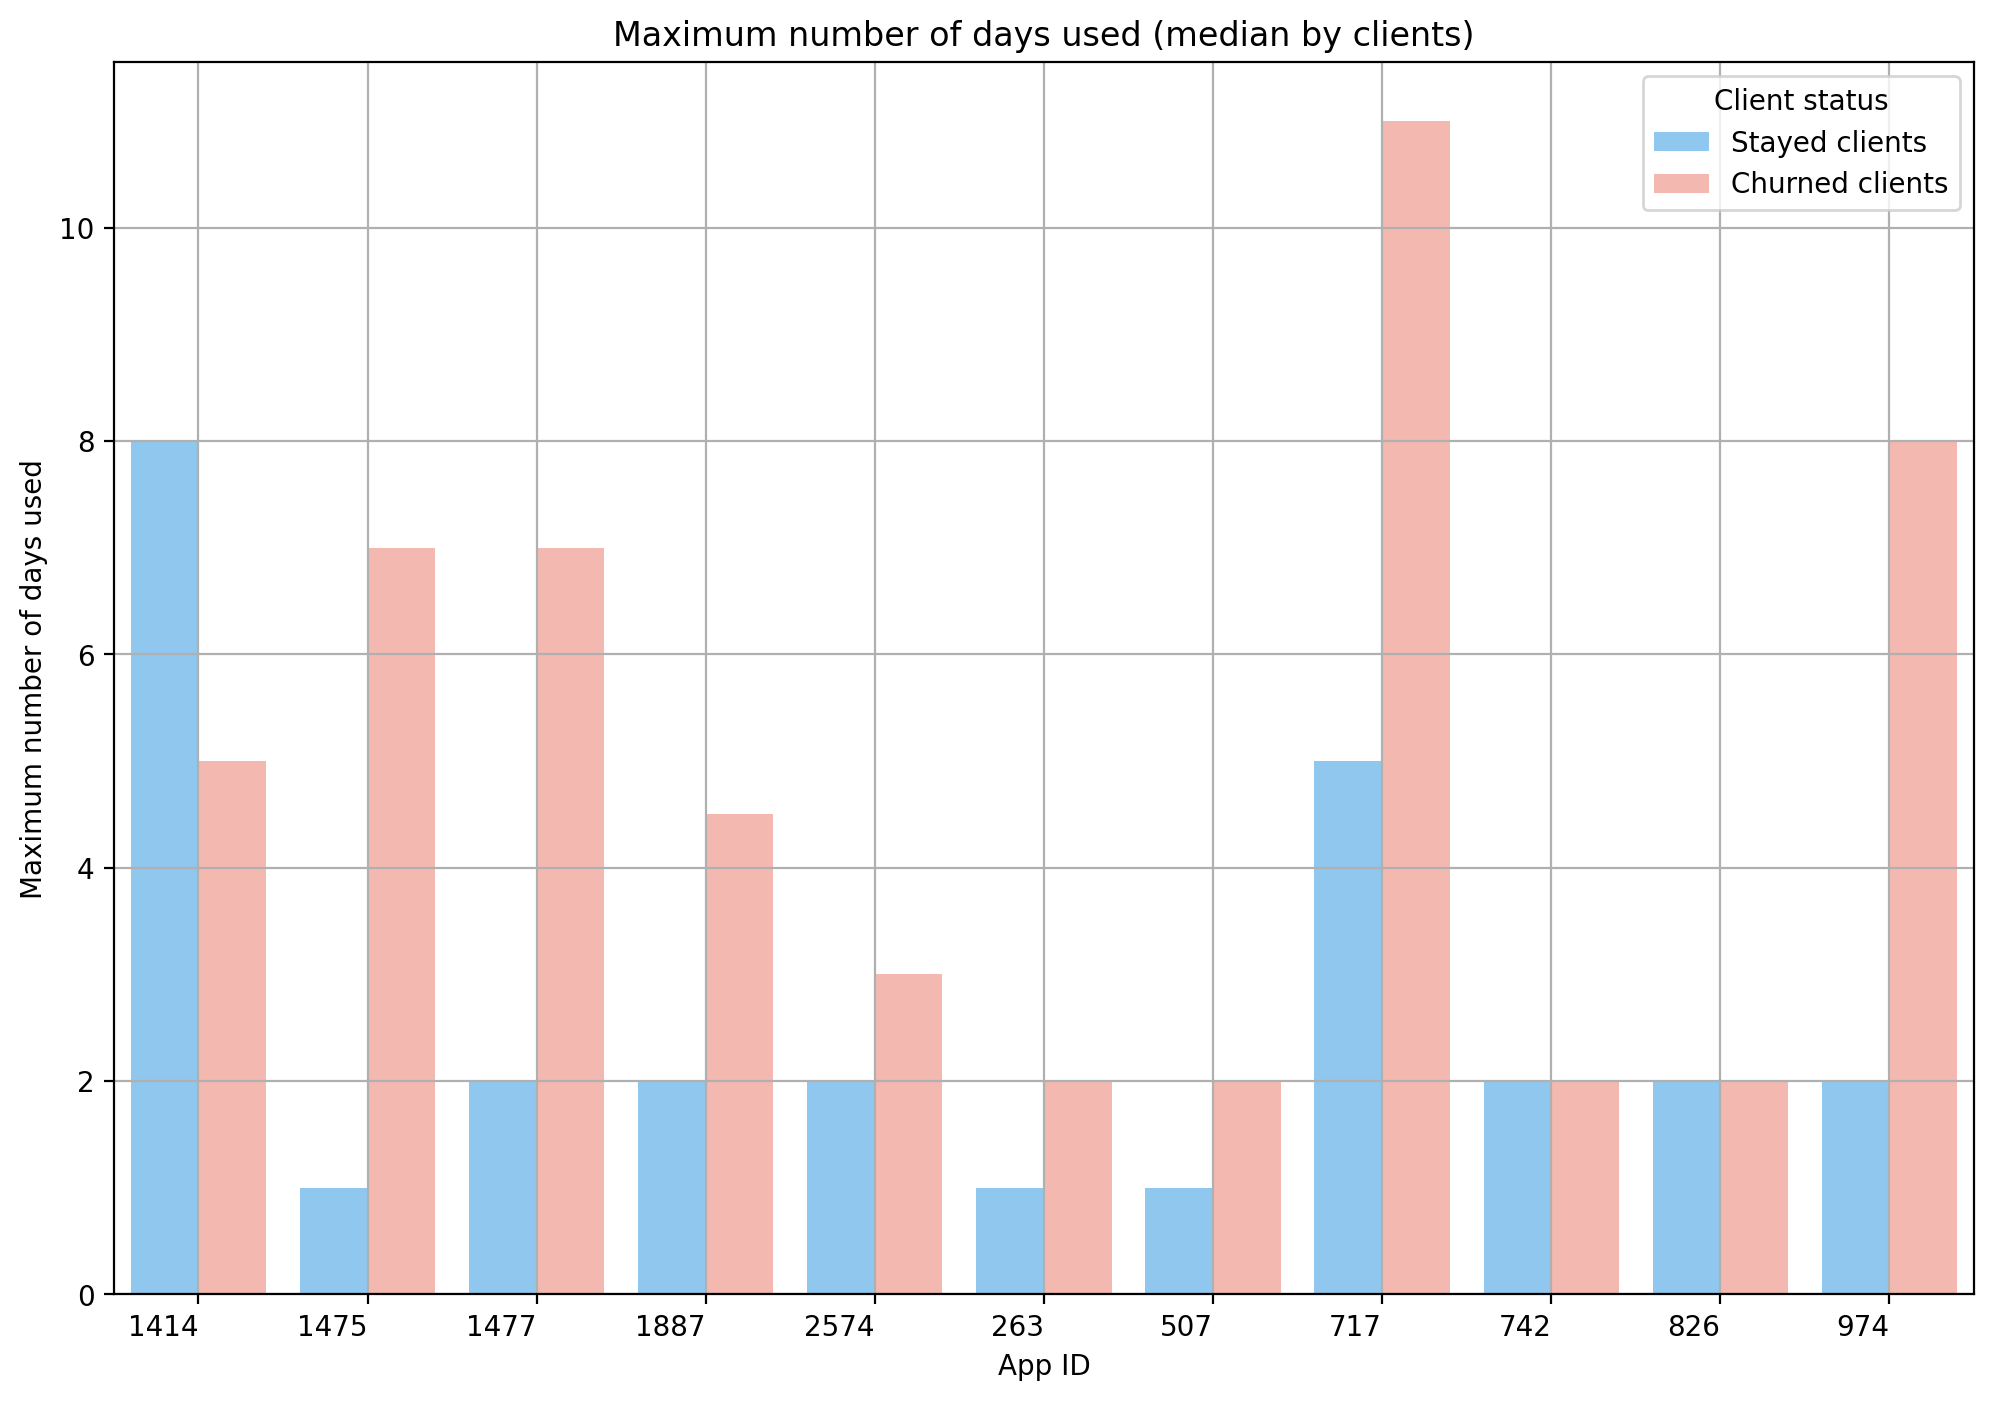

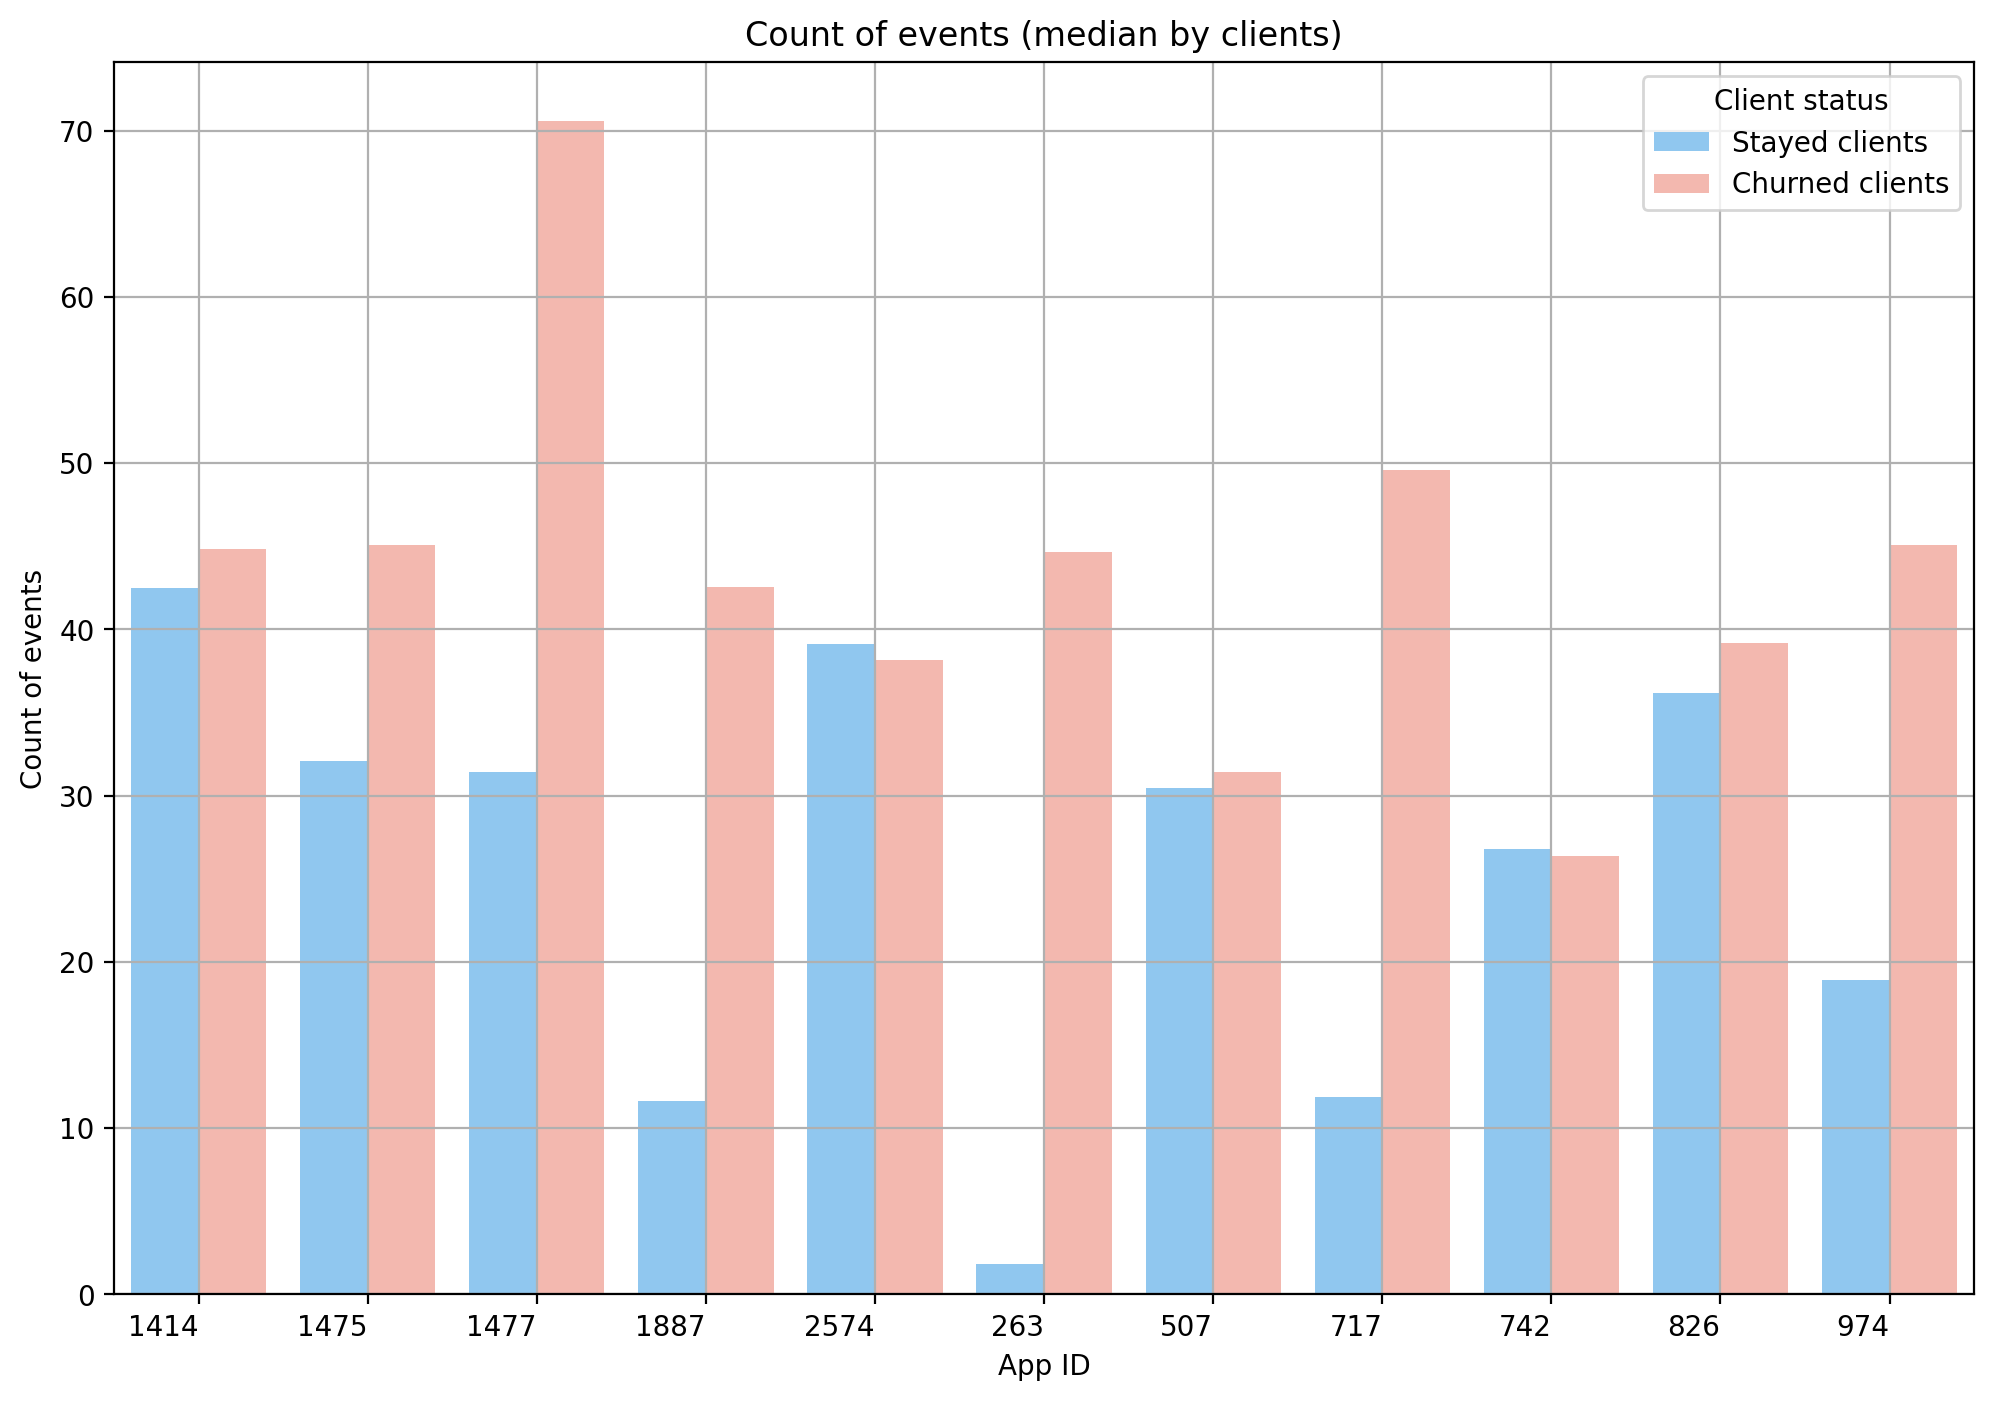

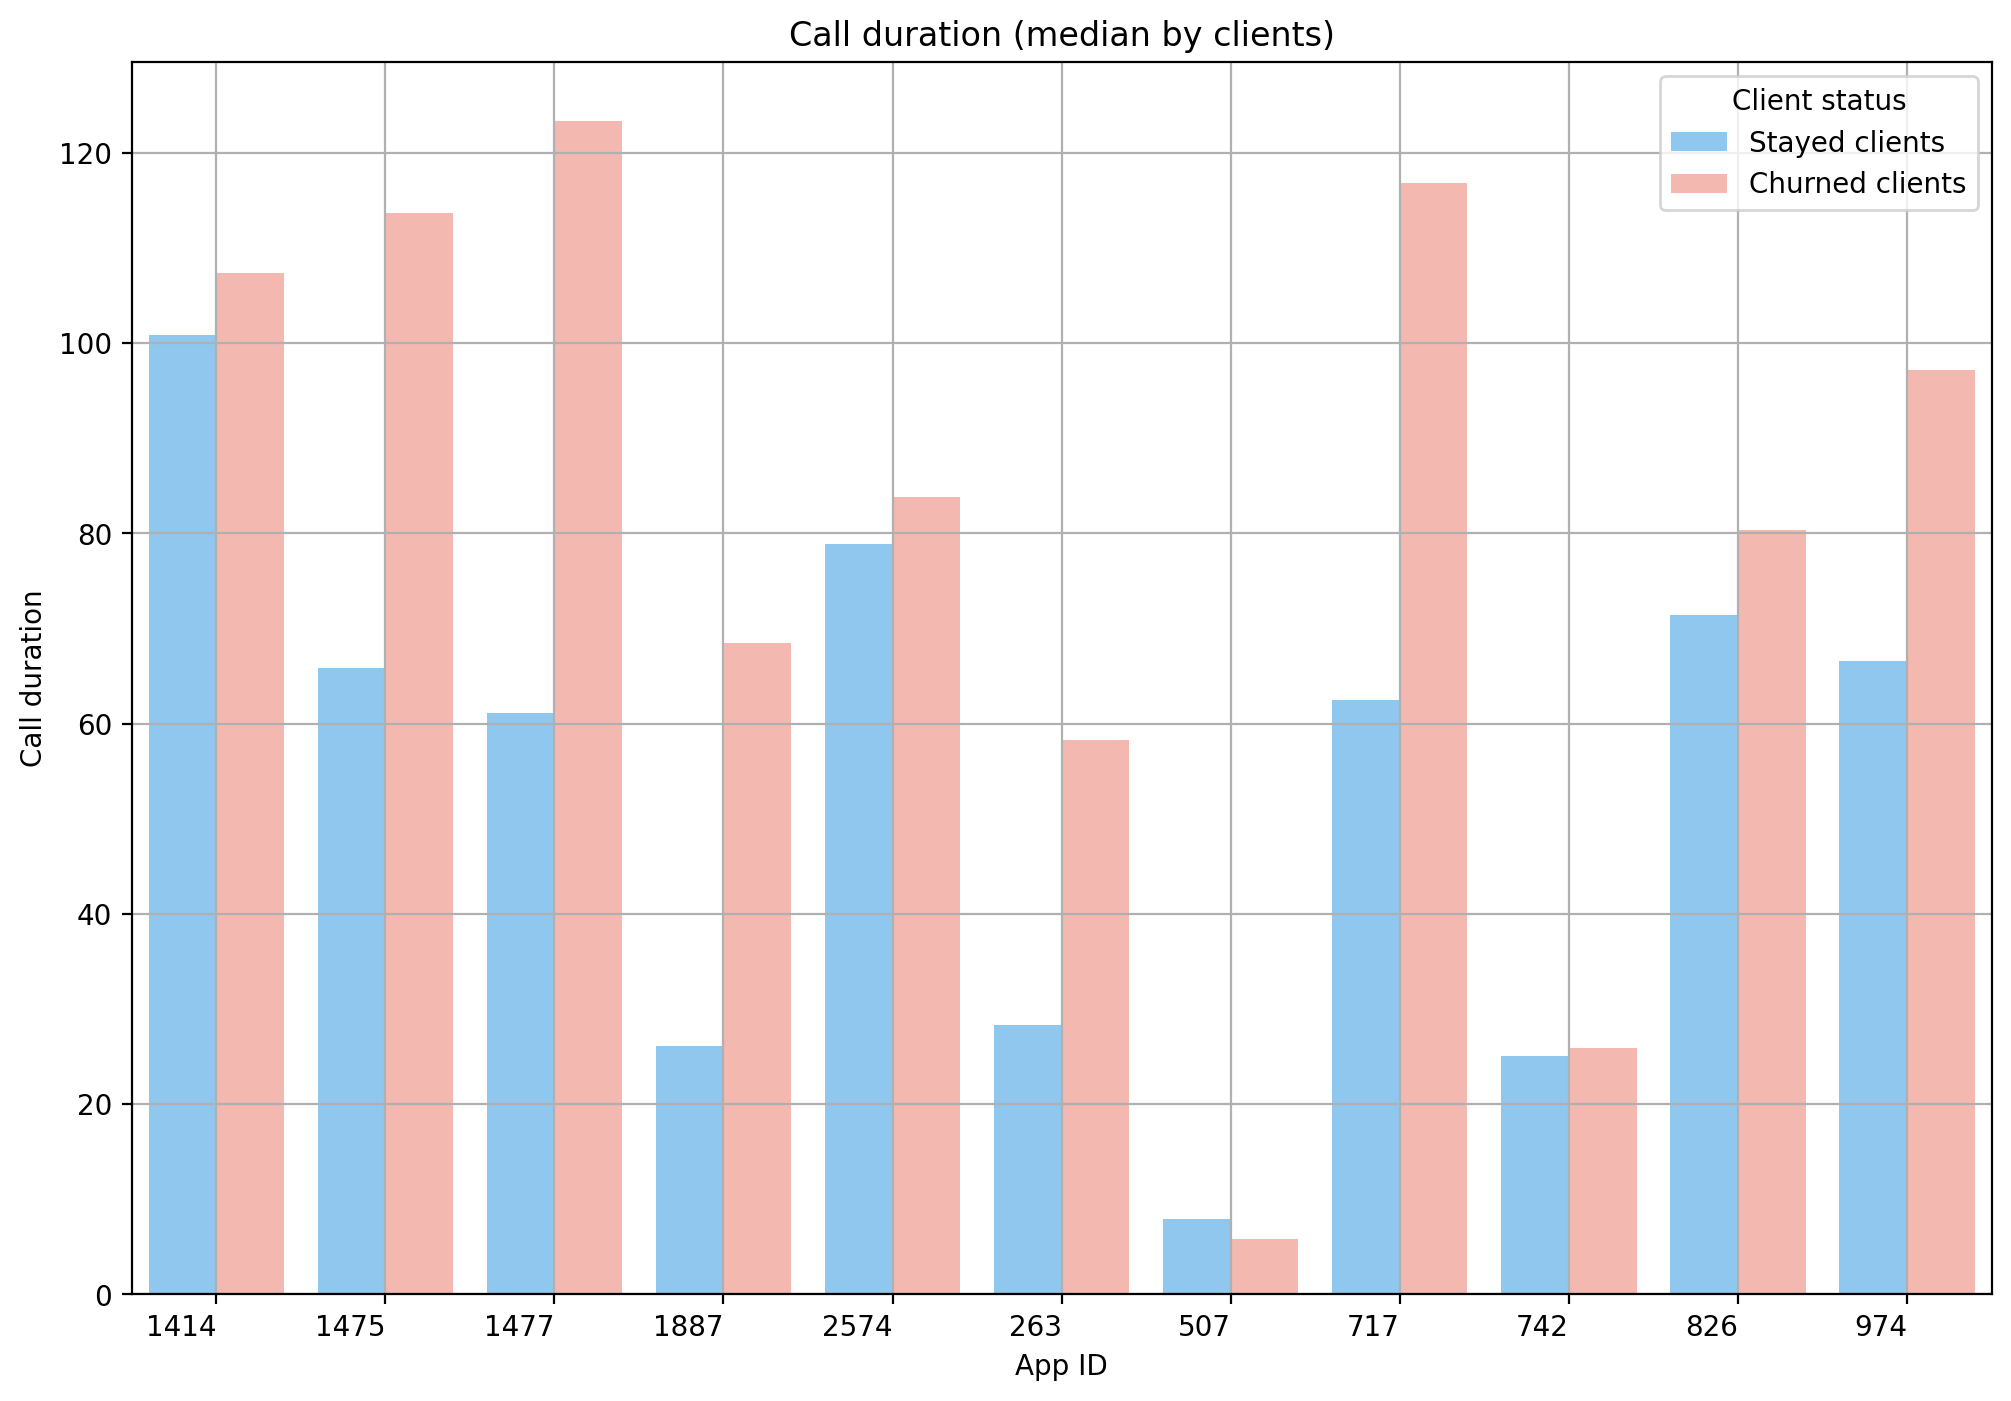

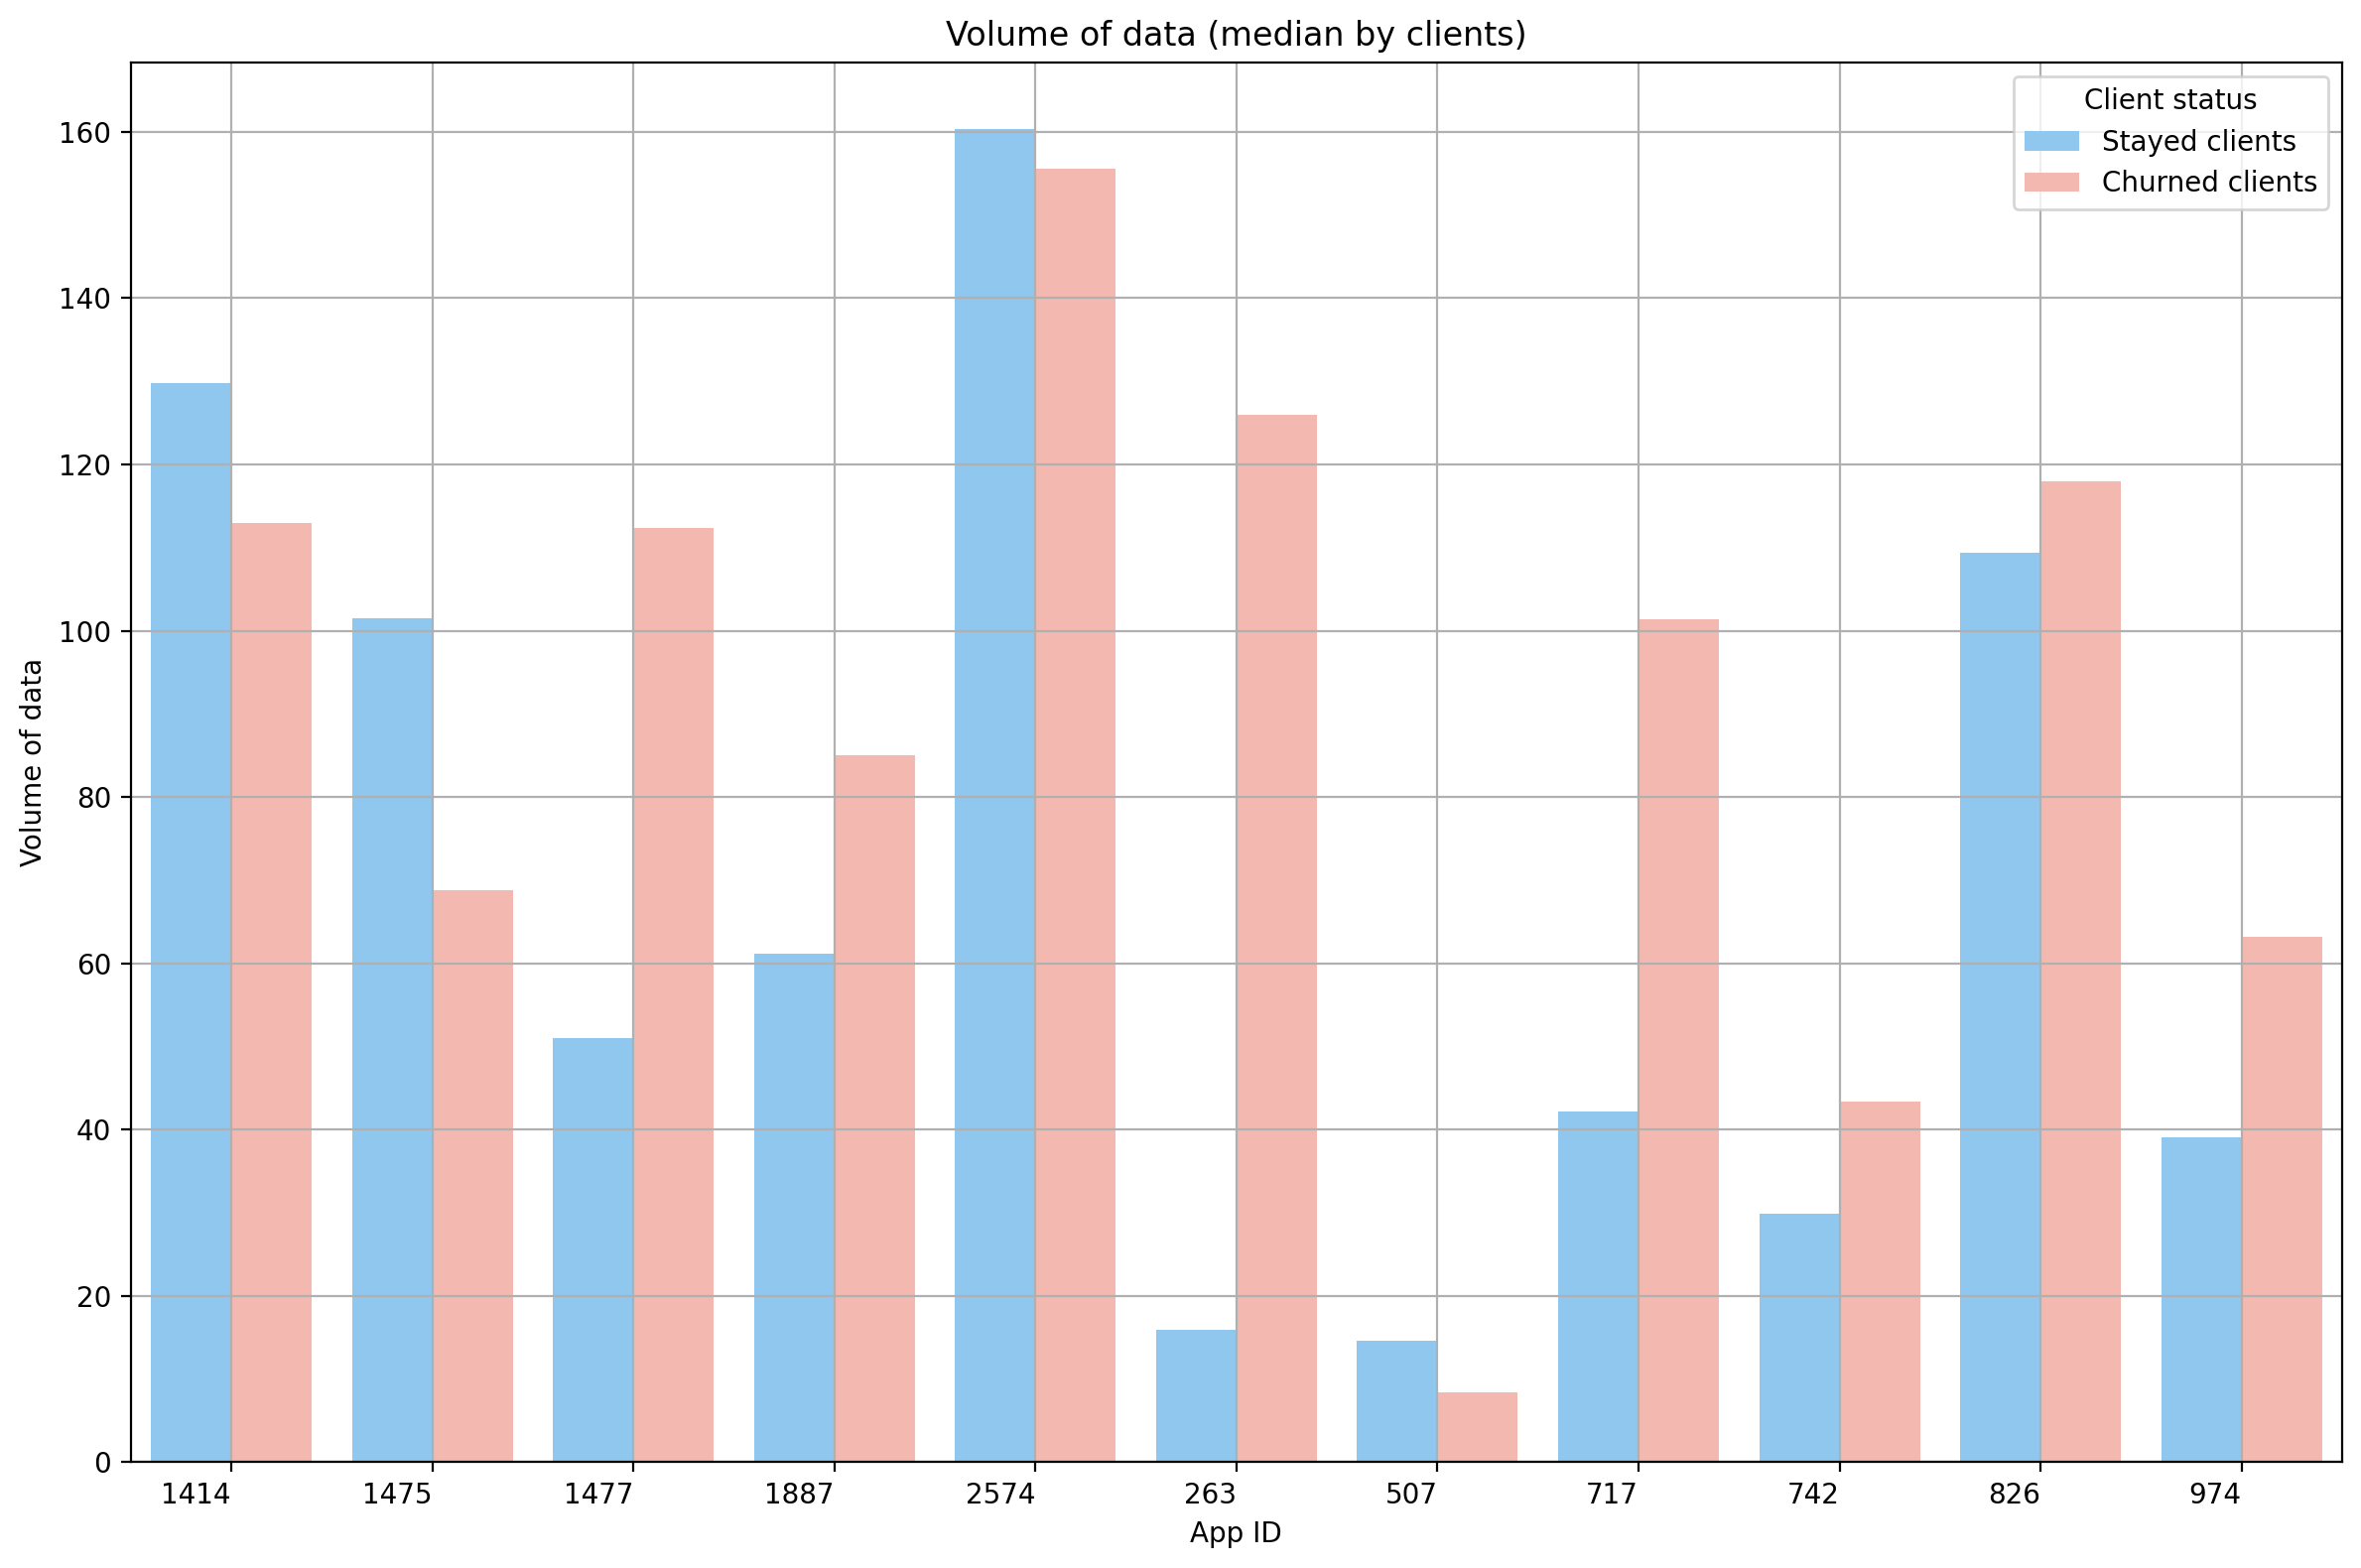

In [9]:
HIGH_CHURN_APPS = ["1414", "1475", "1477", "1887", "2574", "263", "507", "717", "742", "826", "974"]
features = ["MAX_of_day_cnt", "SUM_of_Count_events", "SUM_of_Duration_sec", "SUM_of_Volume_kb"]

df_train_dpi_high_churn = df_train_dpi[df_train_dpi.Application.isin(HIGH_CHURN_APPS)].copy()

grouped = df_train_dpi_high_churn.groupby(["Application", "abon_id", "target"]).sum().reset_index()

grouped = grouped.drop(columns=["abon_id"], axis=1).groupby(["Application", "target"]).median().reset_index()

grouped["target"] = grouped["target"].map({0: NOT_CHURNED_CLIENT_TITLE, 1: CHURNED_CLIENT_TITLE})

# Побудова бар-графіків для кожної ознаки
for i, feature in enumerate(features):
    plt.figure(figsize=(12, 8))
    sns.barplot(
        data=grouped,
        x="Application",
        y=feature,
        hue="target",
        palette={NOT_CHURNED_CLIENT_TITLE: NOT_CHURNED_COLOR, CHURNED_CLIENT_TITLE: CHURNED_COLOR},
    )

    plt.title(f"{DPI_MAPPER[feature]} (median by clients)")
    plt.xlabel('App ID')
    plt.ylabel(DPI_MAPPER[feature])
    plt.legend(title="Client status")
    plt.grid(True)
    plt.xticks(rotation=0, ha="right")

plt.tight_layout()
plt.show()

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns


def dpi_kdeplot(feature_name):
    df = (
        df_train_dpi[df_train_dpi["is_susp_app"] == True]
        .groupby(["abon_id", "target"])
        .agg({f"{feature_name}": "sum"})
        .reset_index()
    )

    plt.figure(figsize=(6, 3))
    sns.kdeplot(
        data=df,
        x=feature_name,
        hue="target",
        fill=True,
        palette={0: NOT_CHURNED_COLOR, 1: CHURNED_COLOR},
        common_norm=False,
    )
    # ENG
    plt.title(f"{DPI_MAPPER[feature_name]} (sum of apps by clients)")
    plt.xlabel(DPI_MAPPER[feature_name])
    plt.ylabel("Density")
    plt.legend(title="Target", labels=SNS_TARGET_LABELS)
    plt.show()

/Users/yaroslav/.pyenv/versions/3.10.13/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yaroslav/.pyenv/versions/3.10.13/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/yaroslav/.pyenv/versions/3.10.13/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


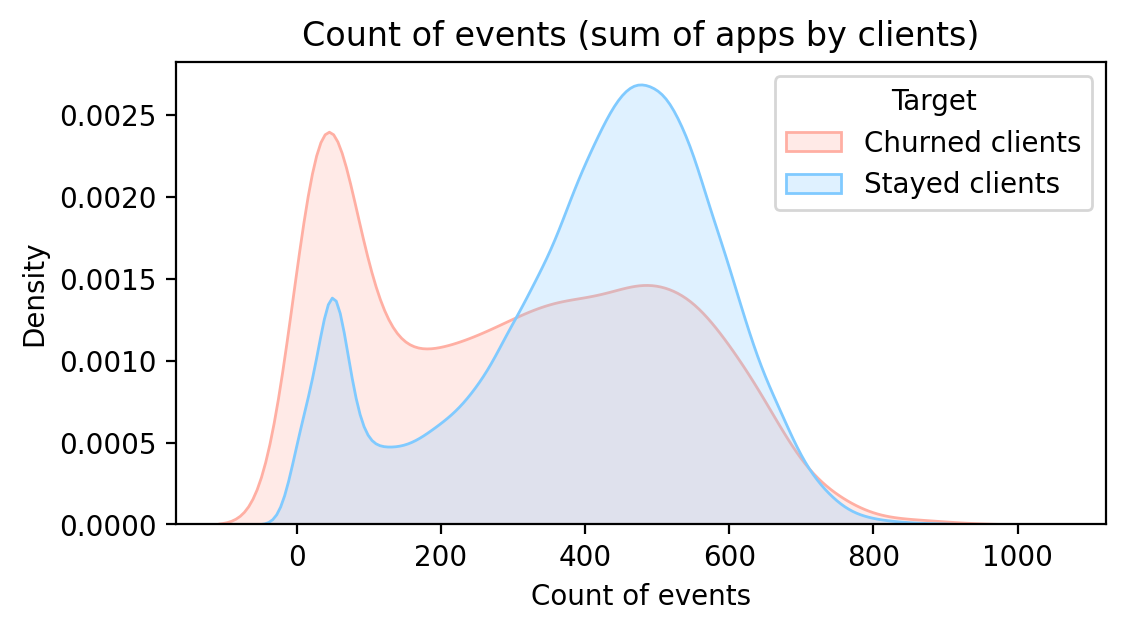

In [19]:
dpi_kdeplot("SUM_of_Count_events")

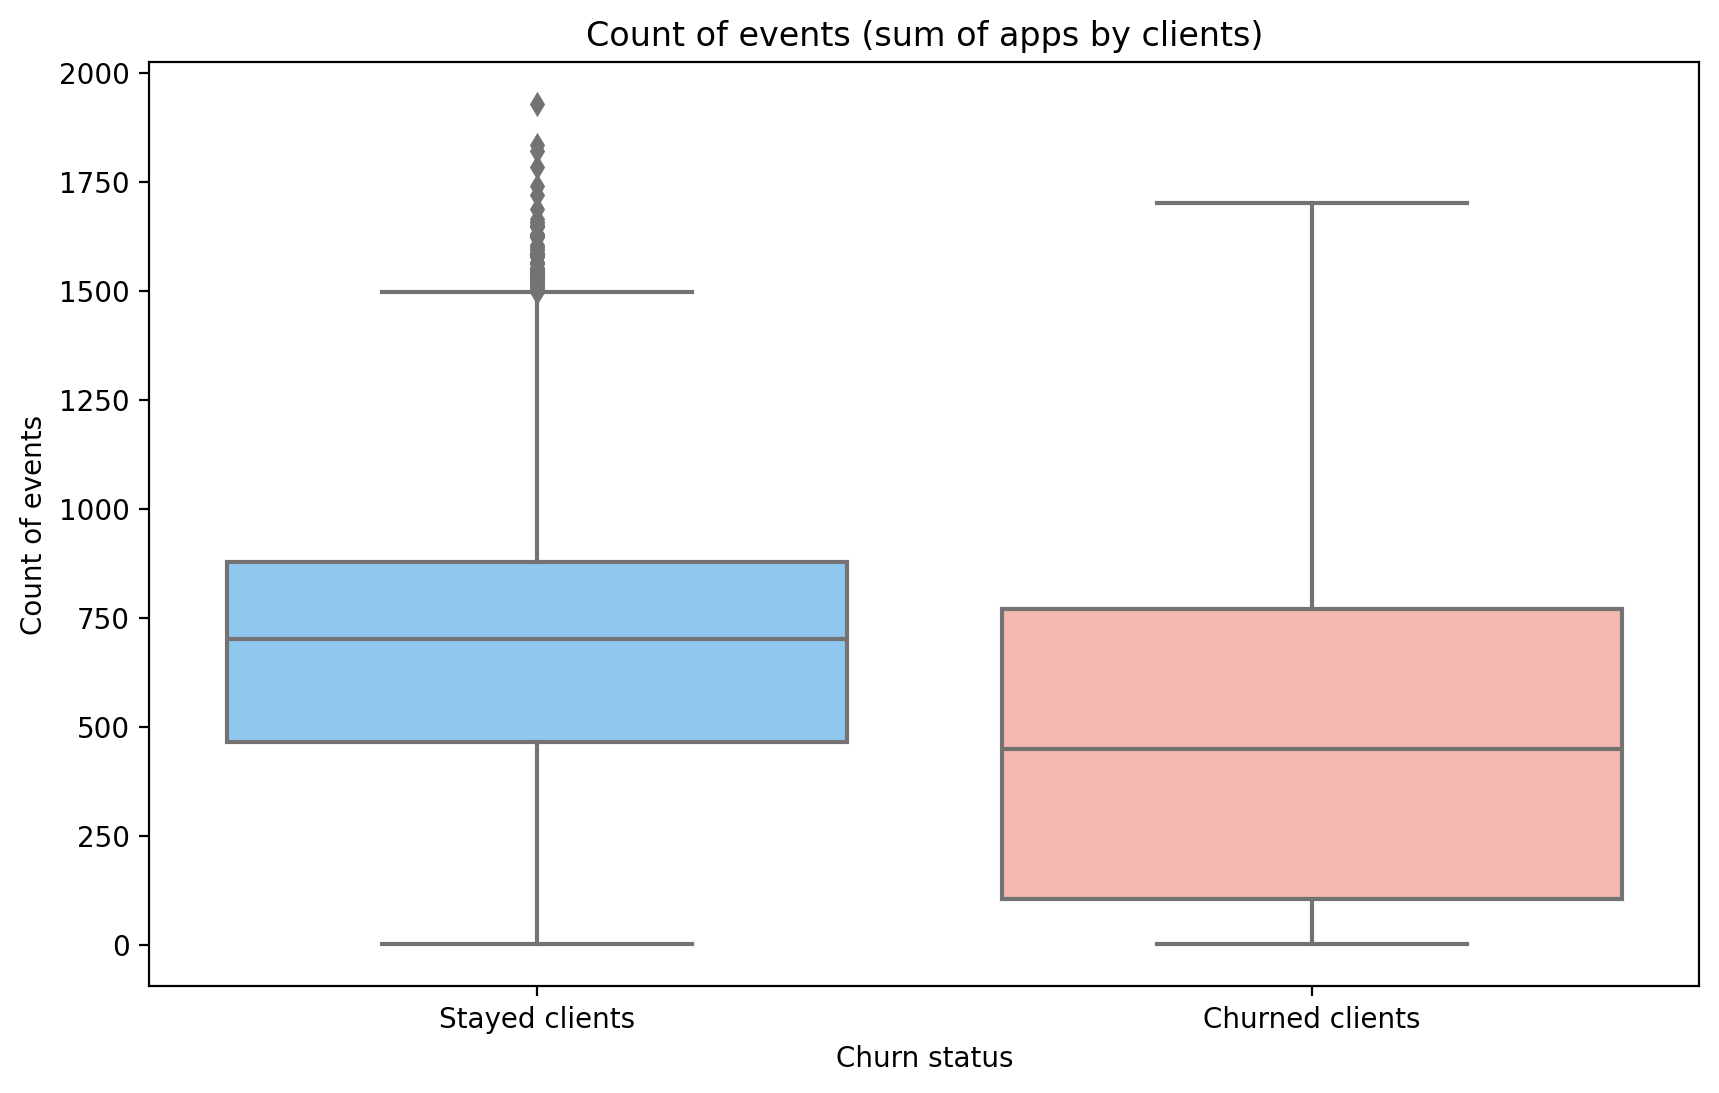

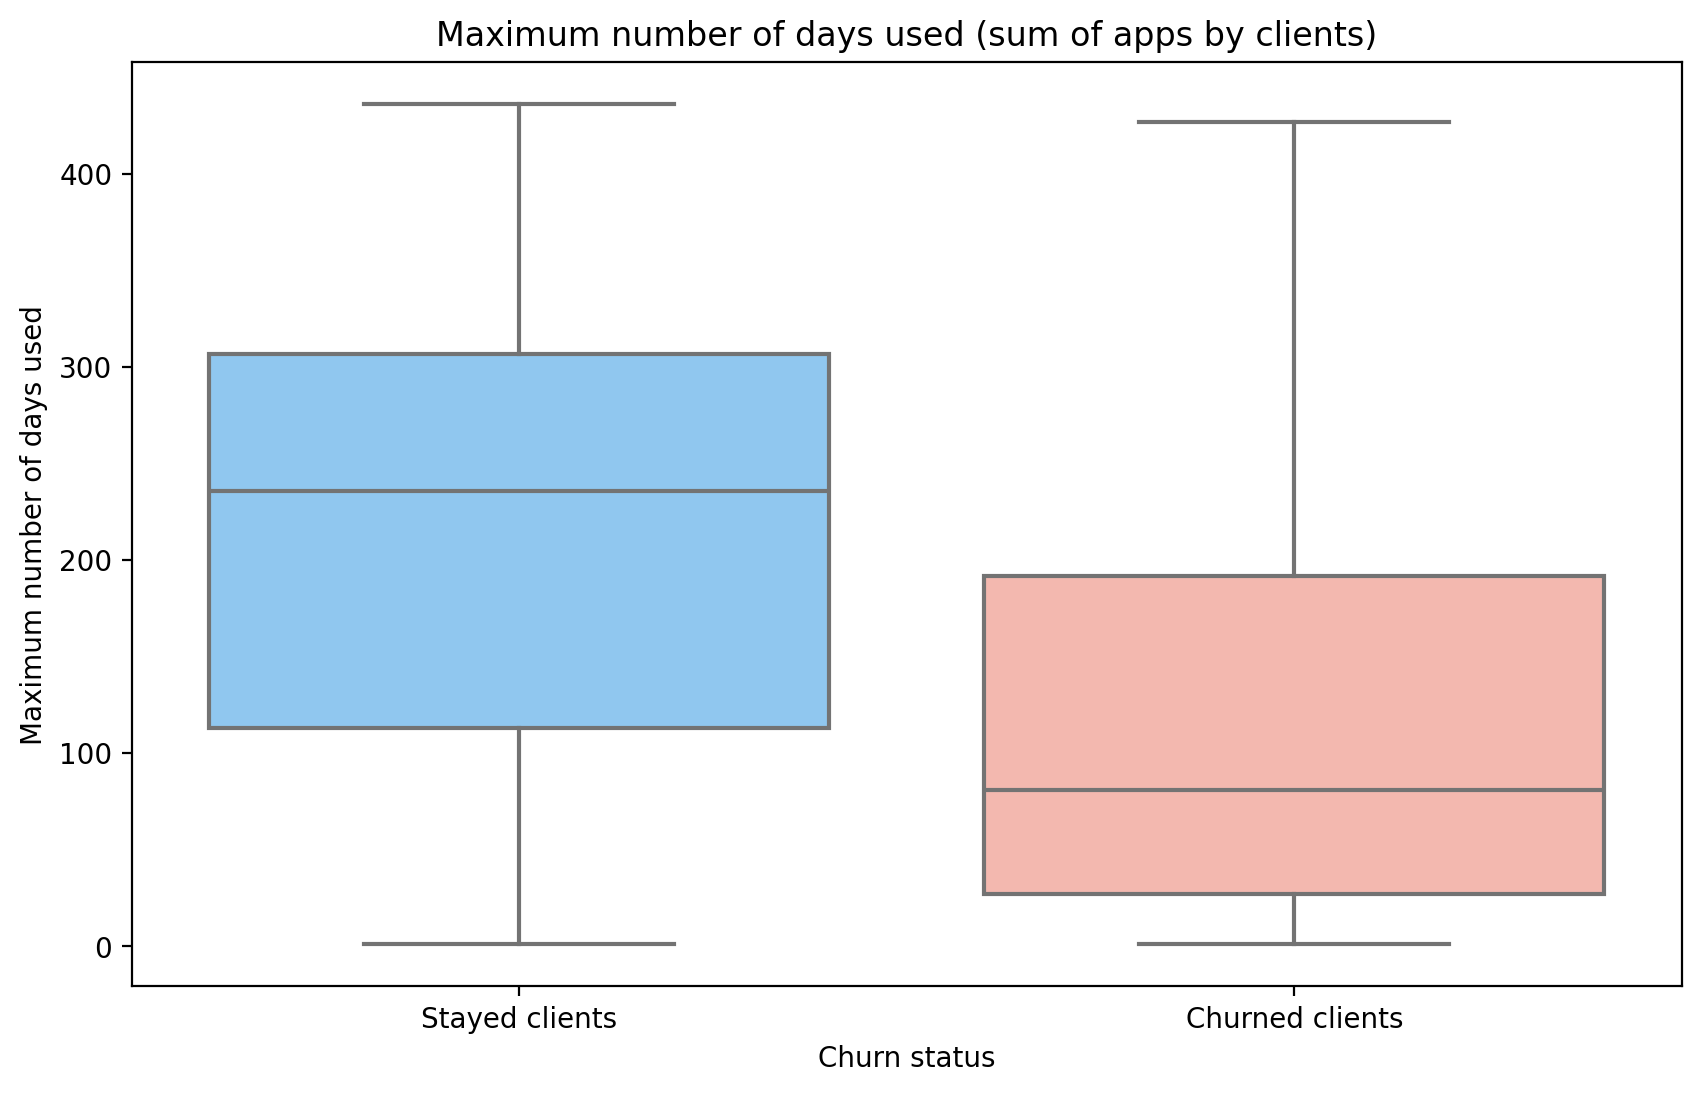

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

activ_columns = ["SUM_of_Count_events", "MAX_of_day_cnt"]

top_app_df_train_dpi = df_train_dpi[df_train_dpi["is_popular_app"] == True]
df_train_dpi["target"] = df_train_dpi["target"].astype(int)
df = top_app_df_train_dpi.groupby(["target", "abon_id"])[activ_columns].sum().reset_index()

# Replace target values with label 1 and label 2
df["target"] = df["target"].replace({0: NOT_CHURNED_CLIENT_TITLE, 1: CHURNED_CLIENT_TITLE})

for column in activ_columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(
        x="target",
        y=column,
        data=df,
        palette={NOT_CHURNED_CLIENT_TITLE: NOT_CHURNED_COLOR, CHURNED_CLIENT_TITLE: CHURNED_COLOR},
    )
    plt.title(f"{DPI_MAPPER[column]} (sum of apps by clients)")
    plt.xlabel("Churn status")
    plt.ylabel(DPI_MAPPER[column])
    plt.show()

In [ ]:
df_train_dpi[df_train_dpi["is_susp_app"] == True].Application.unique()

array(['258', '598', '677', '690', '716', '850', '589'], dtype=object)

/Users/yaroslav/.pyenv/versions/3.10.13/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yaroslav/.pyenv/versions/3.10.13/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


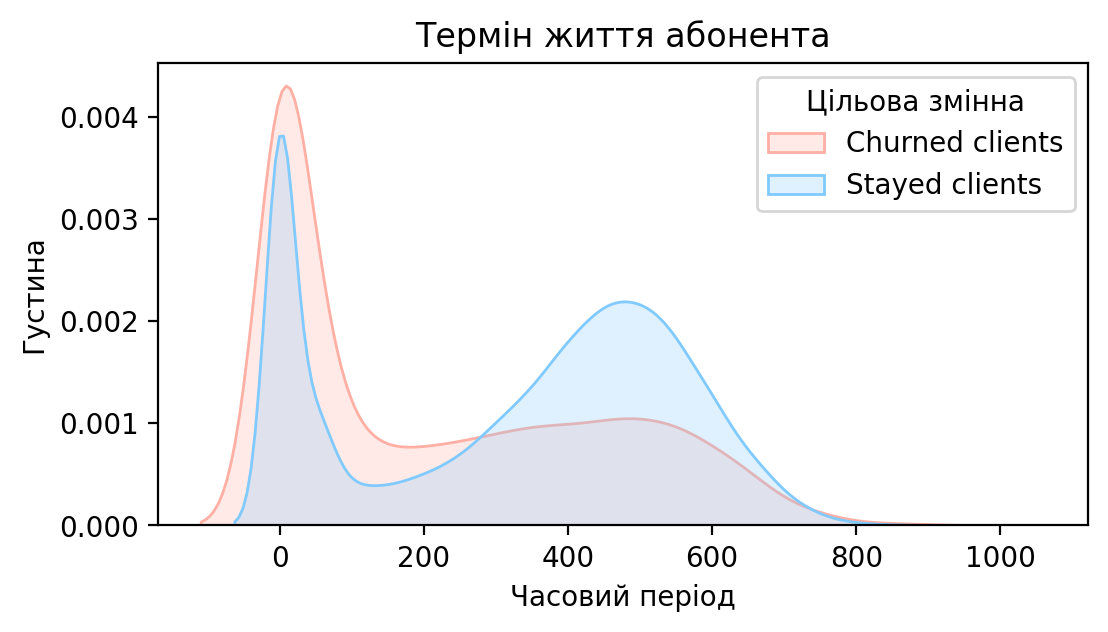

<Figure size 1280x960 with 0 Axes>

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(6, 3))
sns.kdeplot(
    data=train_data,
    x="SUM_of_Count_events_susp_app_sum",
    hue="target",
    fill=True,
    palette={0: NOT_CHURNED_COLOR, 1: CHURNED_COLOR},
    common_norm=False,
)
plt.title("Термін життя абонента")
plt.xlabel("Часовий період")
plt.ylabel("Густина")
plt.legend(title="Цільова змінна", labels=SNS_TARGET_LABELS)
plt.show()

plt.savefig("SUM_of_Count_events.png")

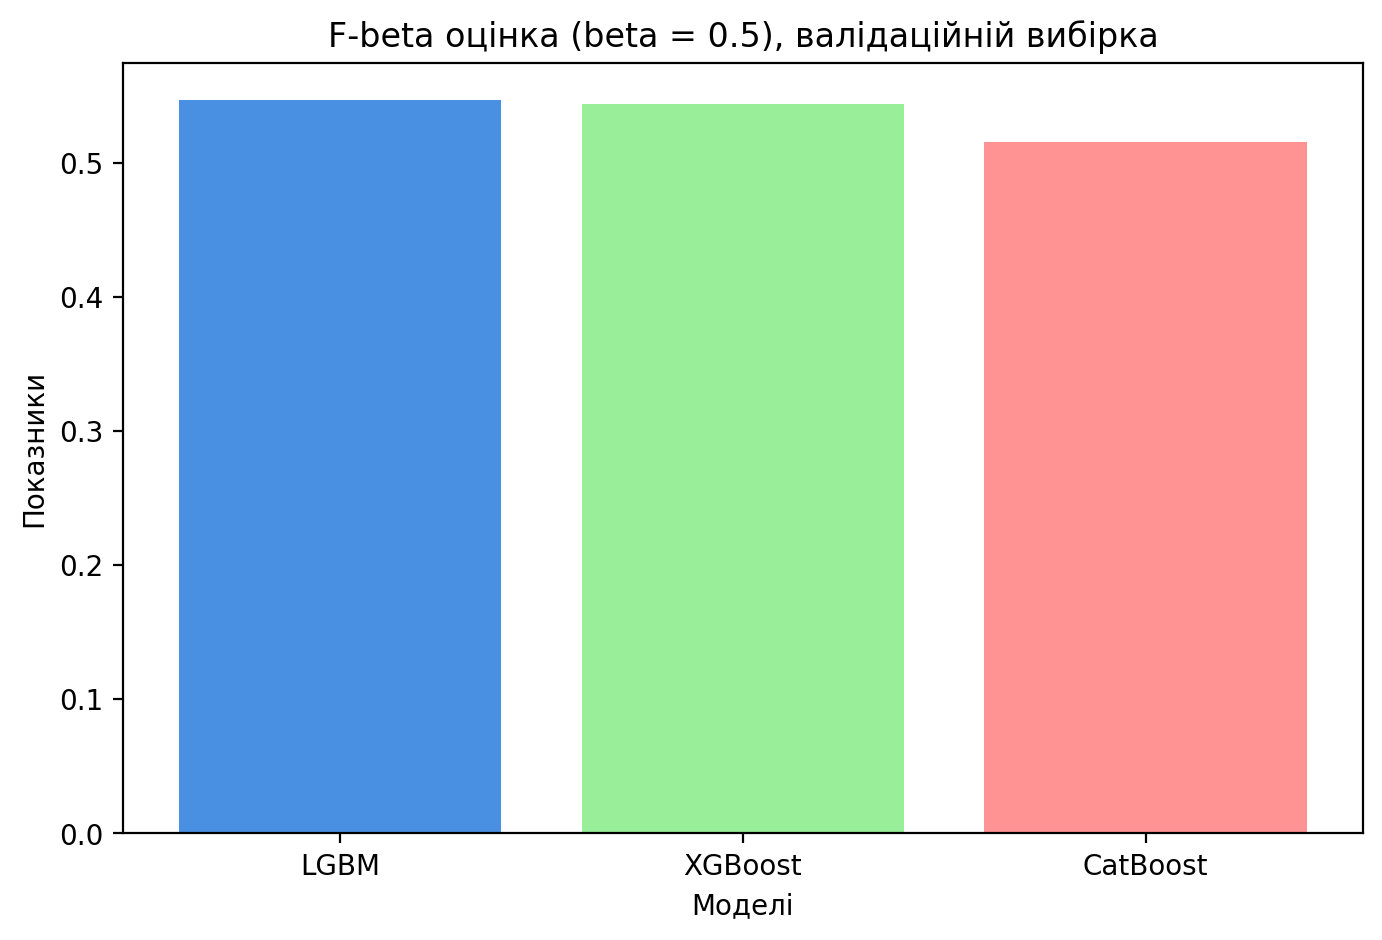

In [99]:
import matplotlib.pyplot as plt

models = ["LGBM", "XGBoost", "CatBoost"]
values = [0.547, 0.544, 0.516]

# Create bar plot
plt.figure(figsize=(8, 5))
plt.bar(models, values, color=["#4A90E2", "#99EE99", "#FF9393"])

# Add labels and title
plt.xlabel("Моделі")
plt.ylabel("Показники")
plt.title("F-beta оцінка (beta = 0.5), валідаційній вибірка")

# Show the plot
plt.show()